## PartMC training and testing data split

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# load data
df = pd.read_csv('../Data/PartMC_data/PartMC_data.csv')

group_col = df.columns[0]
groups = df[group_col]

splitter = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state=42)

for train_idxs, test_idxs in splitter.split(df, groups=groups):
    train = df.iloc[train_idxs]
    valid = df.iloc[test_idxs]


train.to_csv('../Data/PartMC_data/PartMC_train.csv', index=False)
valid.to_csv('../Data/PartMC_data/PartMC_test.csv', index=False)

### Introduction
This script implements a ResNet-inspired neural network for predicting the aerosol mixing state index (χ) using chemical and environmental features. The model is trained (90%), validated (5%) and evaluated (5%) on the PartMC simulation dataset.

Key steps:
1. Data preprocessing: Standardization of input features to a normal distribution.
2. Model definition: A deep residual network (ResNet-like) is employed for regression.
3. Training and validation: Optimized using MSE loss, with gradient clipping for stability.
4. Evaluation: Metrics include MSE, RMSE, MAE, MAPE, and R² for PartMC testing and MEGAPOLI observational datasets.
5. Visualization: Scatter plots with density and performance annotations for model predictions on PartMC testing dataset.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random


# Set random seed for reproducibility
def set_seed(seed):
    """
    Sets the random seed for Python, NumPy, and PyTorch to ensure reproducibility.

    Args:
        seed (int): The seed value to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed = 42
set_seed(seed)

In [ ]:
features = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

# Load the datasets
partmc_train_data = pd.read_csv('../Data/PartMC_data/PartMC_train.csv') # Training data for PartMC
partmc_test_data = pd.read_csv('../Data/PartMC_data/PartMC_test.csv') # Testing data for PartMC
partmc_valid_data = pd.read_csv('../Data/PartMC_data/PartMC_valid.csv') # Validation data for PartMC

megapoli_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine.csv') # MEGAPOLI dataset

# Prepare training data
X_train = partmc_train_data[features]
y_train = partmc_train_data.iloc[:, 23]

X_valid = partmc_valid_data[features]
y_valid = partmc_valid_data.iloc[:, 23]

X_test = partmc_test_data[features]
y_test = partmc_test_data.iloc[:, 23]

# Prepare MEGAPOLI data
X_megapoli = megapoli_data[features]
y_megapoli = megapoli_data.iloc[:, 23]

# Standardize the data (N(0,1) normal distribution)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_valid = scaler_X.transform(X_valid)
X_test = scaler_X.transform(X_test)
X_megapoli = scaler_X.transform(X_megapoli)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_megapoli_tensor = torch.tensor(X_megapoli, dtype=torch.float32)
y_megapoli_tensor = torch.tensor(y_megapoli.values, dtype=torch.float32)

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to the appropriate device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_valid_tensor = X_valid_tensor.to(device)
y_valid_tensor = y_valid_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
X_megapoli_tensor = X_megapoli_tensor.to(device)
y_megapoli_tensor = y_megapoli_tensor.to(device)

In [ ]:
# Create data loaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



# Define ResNet model
class ResNetBlock(nn.Module):
    """
    A single ResNet block with two fully connected layers and a residual connection.
    """
    def __init__(self, in_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    """
    A ResNet-like neural network for regression tasks.
    """
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

# Instantiate and train the model
input_size = X_train.shape[1]
num_blocks = 15
hidden_size = 512
model = ResNet(input_size, num_blocks, hidden_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Training and validation
num_epochs = 30
best_val_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.view(-1), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid_tensor).view(-1)
        val_loss = criterion(val_outputs, y_valid_tensor).item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
    

# Save the best model
model.load_state_dict(best_model)
torch.save(model.state_dict(), '../Model/Foundation_Model.pth')

MSE: 0.0048, RMSE: 0.0690, R2: 0.7251, MAE: 0.0517, MAPE: inf


/var/folders/s7/mrfg68zn5ql0cq0s693qfc0h0000gp/T/ipykernel_65591/2112418586.py:22: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_predictions.numpy() - y_test_tensor.numpy()) / y_test_tensor.numpy())) * 100


Text(0.0, 1.05, 'R$^2$=0.7251 \nRMSE=0.0690 \nMAE=0.0517')

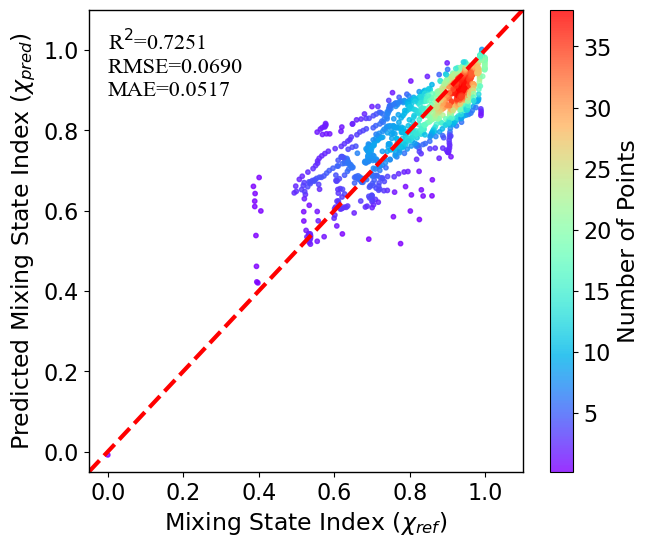

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    # Predict the target values for the test set
    y_test_predictions = model(X_test_tensor).view(-1)
    
    # Calculate Mean Squared Error (MSE)
    mse = criterion(y_test_predictions, y_test_tensor).item()
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate R-squared (R²)
    r2 = 1 - mse / np.var(y_test_tensor.numpy())
    
    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_test_predictions.numpy() - y_test_tensor.numpy()))
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_predictions.numpy() - y_test_tensor.numpy()) / y_test_tensor.numpy())) * 100

# Print evaluation metrics
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Convert tensor data to NumPy arrays for visualization
actual_values = y_test_tensor.numpy()
predicted_values = y_test_predictions.numpy()

# Calculate the density of points
xy = np.vstack([actual_values, predicted_values])
z = gaussian_kde(xy)(xy)

# Create a scatter plot with density color
fig, ax = plt.subplots(figsize=(7, 6))
scatter = plt.scatter(actual_values, predicted_values, c=z, s=10, cmap='rainbow', alpha=0.8)

# Add a color bar to indicate density
cbar = plt.colorbar(scatter, label='Number of Points', orientation='vertical')
cbar.set_label('Number of Points', fontsize=17)
cbar.ax.tick_params(labelsize=16)

# Add labels, ticks, and axis limits
plt.xlabel('Mixing State Index ($\chi_{ref}$)', fontsize=17)
plt.ylabel('Predicted Mixing State Index ($\chi_{pred}$)', fontsize=17)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlim(-0.05, 1.1)
plt.ylim(-0.05, 1.1)

# Add a diagonal line (y=x) for reference
plt.plot([-0.05, 1.1], [-0.05, 1.1], color='r', linestyle='--', linewidth=3)

# Style the plot's spines
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Add text annotations for performance metrics
textstr = f'R$^2$={r2:.4f} \nRMSE={rmse:.4f} \nMAE={mae:.4f}'
plt.text(0.0, 1.05, textstr, fontsize=16, fontname='Times New Roman', verticalalignment='top')

# Save the plot as a high-resolution image
plt.savefig('../graphics/foundational_model_performance.pdf', dpi=400, bbox_inches='tight')


In [8]:
# Evaluate the model on MEGAPOLI data
with torch.no_grad():  # Disable gradient calculation (no need for backpropagation during evaluation)
    # Get model predictions for the MEGAPOLI dataset
    megapoli_predictions = model(X_megapoli_tensor).view(-1)  # Flatten predictions to 1D tensor
    
    # Calculate Mean Squared Error (MSE)
    mse_megapoli = criterion(megapoli_predictions, y_megapoli_tensor).item()
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse_megapoli = np.sqrt(mse_megapoli)
    
    # Calculate R-squared (R2) score
    r2_megapoli = 1 - mse_megapoli / np.var(y_megapoli_tensor.cpu().numpy())
    
    # Calculate Mean Absolute Error (MAE)
    mae_megapoli = np.mean(np.abs(megapoli_predictions.cpu().numpy() - y_megapoli_tensor.cpu().numpy()))
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_megapoli = np.mean(
        np.abs((megapoli_predictions.cpu().numpy() - y_megapoli_tensor.cpu().numpy()) / y_megapoli_tensor.cpu().numpy())
    ) * 100

    # Print evaluation metrics
    print(f'MEGAPOLI Data - MSE: {mse_megapoli:.4f}, RMSE: {rmse_megapoli:.4f}, '
          f'R2: {r2_megapoli:.4f}, MAE: {mae_megapoli:.4f}, MAPE: {mape_megapoli:.4f}%')


MEGAPOLI Data - MSE: 0.0060, RMSE: 0.0777, R2: -0.2200, MAE: 0.0509, MAPE: 9.1251%


In [70]:
import optuna
print(optuna.__version__)

/Users/user/miniconda3/envs/partmc/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.6.1


In [71]:
import torch
print(torch.__version__)

2.3.0
